In [1]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Importando dados

Aqui usaremos o dataset CIFAR10 (https://www.tensorflow.org/datasets/catalog/cifar10).

In [24]:
# carregando dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()

Faremos algumas adequações para que os dados sejam usados no modelo de CNN. Basicamente, colocamos os valores dos pixels em uma escala de 0 a 1, visto que os valores originais dos pixels das imagens correspondem a uma escala de 0 a 255. Também transformamos nossa variável alvo em uma codificação one-hos

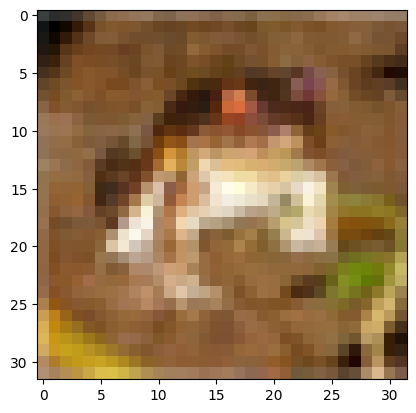

In [20]:
plt.imshow(trainX[0], cmap='gray');

In [25]:
# fazendo um reshape no dataset para ter um único canal | Não é mais necessário fazer o reshape para o CIFAR10
# trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
# testX = testX.reshape((testX.shape[0], 28, 28, 1))

# Convertendo valores dos pixels em float
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# normalização para escala [0-1]
trainX = trainX / 255.0
testX = testX / 255.0

# remove a segunda dimensão
trainY = trainY.squeeze()
testY = testY.squeeze()

# transformando a variável alvo (target) para uma codificação one hot
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# Construindo o modelo

O modelo usado será bem simples:
* Uma única camada convolucional com 32 filtros de tamanho 3 x 3 e função de ativação ReLU
* Camada MaxPooling para redução de dimensionalidade
* Transformação do resultado em um vetor
* Camada totalmente conectada com 100 neurônios e função de ativação ReLU
* Camada de saída softmax para estimar a probabilidade da entrada da rede pertencer a cada uma das 10 classes (dígitos 0 a 9)


Para treinamento do modelo, usaremos o algoritmo de otimização clássico do gradiente descendente estocástico (SDG), com a função objetiva como a entropia cruzada categórica. Nossa principal métrica de desempenho será a acurácia

In [60]:
# definindo modelo
def define_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # compilando modelo
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Treinamento do modelo

O treinamento será realizado usando o método da validação cruzada k-partições (k-fold) com k=5. Tal validação cruzada faz a divisão dos dados em 5 grupos de tamanho igual, sendo realizadas 5 treinamentos distintos. A cada treinamento, 4 grupos de dados são utilizados para treinar o modelo e o grupo remanescente é usado para teste do desempenho do modelo treinado.



* O principal intuito da validação k-fold é acessar a incerteza do desempenho do modelo

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4087 - loss: 1.6981 - val_accuracy: 0.4973 - val_loss: 1.4543
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 1.1241 - val_accuracy: 0.5893 - val_loss: 1.2095
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6623 - loss: 0.9520 - val_accuracy: 0.6498 - val_loss: 1.0263
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6968 - loss: 0.8655 - val_accuracy: 0.6631 - val_loss: 1.0015
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7300 - loss: 0.7724 - val_accuracy: 0.6935 - val_loss: 0.8998
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7523 - loss: 0.7117 - val_accuracy: 0.5226 - val_loss: 1.7443
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7713 - loss: 0.6636 - val_accuracy: 0.7005 - val_loss: 0.9107
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7883 - loss: 0.6026

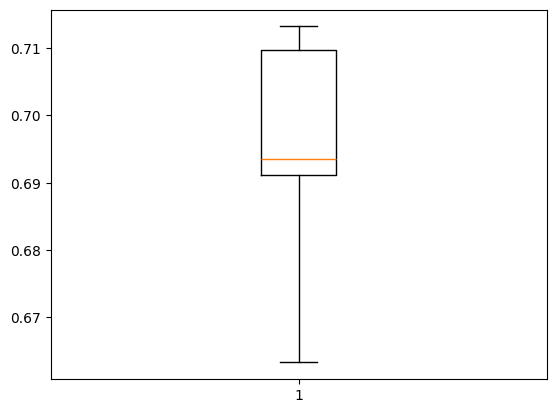

In [62]:
scores = []
histories = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
for train_ix, test_ix in kfold.split(trainX):

    model = define_model()

    # recorta dados de acordo com índices da k-fold
    train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]

    # treinamento do modelo
    history = model.fit(train_data, train_target,
                        epochs=15, batch_size=32,
                        validation_data=(val_data, val_target),
                        verbose=1, callbacks=[callback])

    # desempenho do modelo
    _, acc = model.evaluate(val_data, val_target, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # armazena resultados de cada modelo treinado dentro da k-fold
    scores.append(acc)
    histories.append(history)

print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.boxplot(scores)
plt.show()

# Testando modelo no conjunto de teste

Agora avaliaremos o desempenho do modelo em dados do conjunto de teste separado nas etapas iniciais deste exercício
* Abaixo temos a primeira imagem do conjunto de teste

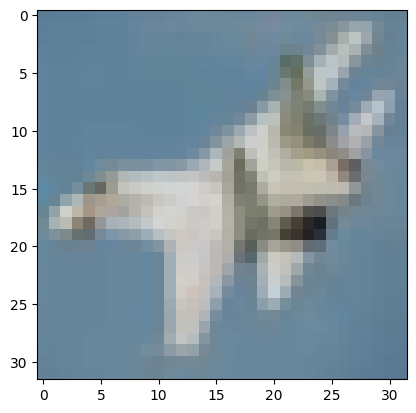

In [64]:
plt.imshow(testX[10], cmap='gray');

In [63]:
pred = np.argmax(model.predict(np.expand_dims(testX[10], axis=0)))

pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


np.int64(0)

In [65]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

'Predição: {pred}'.format(pred=cifar10_labels[pred])

'Predição: airplane'

# Questões avaliativas

1- Houve muita diferença no desempenho da rede treinada quando comparado ao exemplo?

2- Experimente adicionar mais dois blocos de camadas Conv2D (64 filtros 3x3 - relu) + MaxPooling (2 x 2) antes da camada Flatten e compare os resultados.

3- Seguindo o modelo modificado no item anterior, experimente adicionar um Dropout de 20% após cada camada MaxPooling. Comente os resultados obtidos.

# Respostas

1- Sim, houve uma diferença considerável no desempenho da rede. O modelo treinado com o CIFAR-10 teve uma acurácia significativamente menor do que o modelo treinado com MNIST. Isso é esperado, pois o CIFAR-10 é um dataset mais complexo, com imagens coloridas e diferentes contextos visuais, enquanto o MNIST possui imagens em tons de cinza de dígitos simples (0 a 9) e com fundo uniforme.

Acurácia: média=59.900 desvio=1.787

2- Ao adicionar dois blocos extras de camadas Conv2D com 64 filtros e MaxPooling antes da camada Flatten, a acurácia do modelo melhorou de proximadamente 6%, passando de 60% para 66%. Isso aconteceu porque o aumento da profundidade da rede permitiu extrair padrões mais complexos e detalhados das imagens, melhorando a capacidade de generalização.

Acurácia: média=66.080 desvio=0.942

3- Após adicionar camadas de Dropout de 20% após cada camada MaxPooling, a acurácia média do modelo aumentou de 66% para 69.4%. Esse aumento indica que o Dropout ajudou a reduzir o overfitting, forçando o modelo a aprender representações mais robustas, ao invés de memorizar os dados de treino.
No entanto, o desvio padrão da acurácia entre as execuções aumentou de 0,9 para 1.7, indicando que o modelo ficou ligeiramente mais sensível à aleatoriedade da inicialização dos pesos ou da ordem dos dados.
De forma geral, o resultado mostra que o Dropout pode melhorar o desempenho médio, mas também traz um pouco mais de variabilidade, o que é normal e pode ser ajustado com mais épocas.

10 Épocas: Acurácia: média=68.706 desvio=1.951

15 Épocas: Acurácia: média=69.416 desvio=1.770